In [62]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization, Activation
from keras.initializers import glorot_uniform
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.metrics import jaccard_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import keras

In [44]:
y_train = pd.read_csv('../Dataset_MovieSummaries/y_train1.csv')
y_train.drop('Unnamed: 0', axis=1, inplace=True)
x_train = pd.read_csv('../Dataset_MovieSummaries/X_train1.csv')
x_train.drop('Unnamed: 0', axis=1, inplace=True)
y_test = pd.read_csv('../Dataset_MovieSummaries/y_test1.csv')
y_test.drop('Unnamed: 0', axis=1, inplace=True)
x_test = pd.read_csv('../Dataset_MovieSummaries/X_test1.csv')
x_test.drop('Unnamed: 0', axis=1, inplace=True)

In [45]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [46]:
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
x_val.reset_index(drop = True, inplace = True)
y_val.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [57]:

precision = {}
recall= {}
f1={}
jaccard = {}

## Deep learning

In [48]:

def step_decay_schedule(initial_lr=0.001, decay_factor=0.5, step_size=10):
    def schedule(epoch):
        return max(initial_lr * math.pow(decay_factor, math.floor((1+epoch)/step_size)), 0.000001)
    return LearningRateScheduler(schedule)
    
learning_rate = 0.0001  # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)
# Define the model
model = Sequential()
model.add(Dense(512, input_shape=(x_train.shape[1],), kernel_initializer=glorot_uniform(),kernel_regularizer=l2(0.05)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128, kernel_initializer=glorot_uniform(),kernel_regularizer=l2(0.05)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer=glorot_uniform(),kernel_regularizer=l2(0.05)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='sigmoid'))  # Output layer with softmax activation for multiclass classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print model summary
model.summary()

/home/asolta2s/myenv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,638 (2.25 MB)

 Trainable params: 588,230 (2.24 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [49]:
%%time
batch_size = 256
epochs = 200
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                   shuffle=True,
                   callbacks=[step_decay_schedule(initial_lr=0.0001, decay_factor=0.6, step_size=10),early_stopping])

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1821 - loss: 47.3736 - val_accuracy: 0.2017 - val_loss: 42.6222 - learning_rate: 1.0000e-04
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1787 - loss: 41.3441 - val_accuracy: 0.2091 - val_loss: 37.1674 - learning_rate: 1.0000e-04
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1789 - loss: 36.0555 - val_accuracy: 0.2278 - val_loss: 32.4148 - learning_rate: 1.0000e-04
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1743 - loss: 31.4581 - val_accuracy: 0.2431 - val_loss: 28.2772 - learning_rate: 1.0000e-04
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1880 - loss: 27.4432 - val_accuracy: 0.2492 - val_loss: 24.6757 - learning_rate: 1.0000e-04
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1972 - loss: 23.9539 - val_accuracy: 0.2548 - val_loss: 21.5432 - learning_rate: 1.0000e-04
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step 

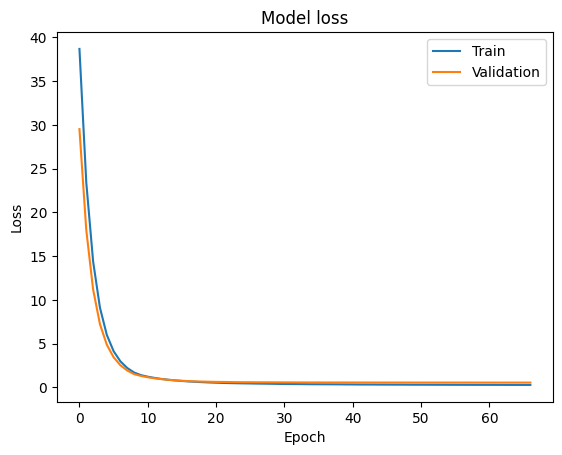

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [52]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4930 - loss: 2.0356
Test Accuracy: 49.72%


In [58]:

# Predict and evaluate the model
y_pred_dl = model.predict(x_test)
y_pred_binary_dl = (y_pred_dl >= 0.5).astype(int)
accuracy_dl = accuracy_score(y_test, y_pred_binary_dl)
print(f'Accuracy: {accuracy_dl:.2f}')

# Detailed classification report
report = classification_report(y_test, y_pred_binary_dl, target_names=list(y_train.columns))
print(report)
precision['Deep Learning'], recall['Deep Learning'], f1['Deep Learning'], _ = precision_recall_fscore_support(y_test, y_pred_binary_dl, average='micro')


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.31
               precision    recall  f1-score   support

       Action       0.69      0.54      0.61       782
       Comedy       0.61      0.42      0.50       773
Crime Fiction       0.71      0.58      0.64       774
       Horror       0.75      0.71      0.73       570
 Romance Film       0.78      0.68      0.72       844
     Thriller       0.60      0.34      0.44       724

    micro avg       0.70      0.54      0.61      4467
    macro avg       0.69      0.54      0.60      4467
 weighted avg       0.69      0.54      0.60      4467
  samples avg       0.62      0.58      0.57      4467



/home/asolta2s/myenv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


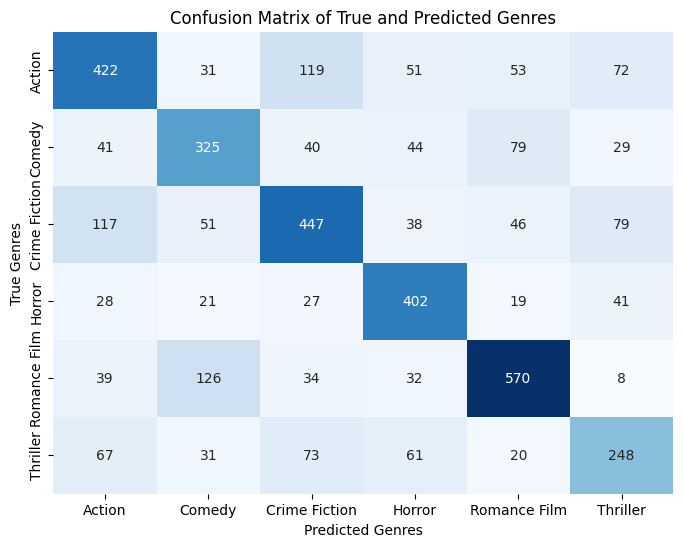

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

confusion_matrix = np.zeros((len(y_train.columns), len(y_train.columns)), dtype=int)

# Populate the confusion matrix
for i in range(len(y_test)):
    true_indices = np.where(y_test.iloc[i] == 1)[0]
    pred_indices = np.where(y_pred_binary_dl[i] == 1)[0]
    for true_label in true_indices:
        for pred_label in pred_indices:
          if pred_label not in true_indices or true_label==pred_label:
            confusion_matrix[true_label, pred_label] += 1

# Convert to DataFrame for better visualization
confusion_df = pd.DataFrame(confusion_matrix, index=y_train.columns, columns=y_train.columns)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Confusion Matrix of True and Predicted Genres")
plt.xlabel("Predicted Genres")
plt.ylabel("True Genres")
plt.show()

In [64]:
print ('jaccard scores for Our model:\n')
print(jaccard_score(y_test, y_pred_binary_dl, average='samples'))
print(jaccard_score(y_test, y_pred_binary_dl, average='macro'))
print(jaccard_score(y_test, y_pred_binary_dl, average=None))

jaccard['Deep Learning'] = jaccard_score(y_test, y_pred_binary_dl, average='samples')

jaccard scores for Our model:

0.5017144986954901
0.4419499235210747
[0.43371017 0.33163265 0.46757322 0.57346648 0.56603774 0.27927928]


In [61]:
model.save('model2.keras')


## Logistic Regression

In [30]:
import time
start_time = time.time()

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(x_train, y_train)

y_pred_lr = clf.predict(x_test)
y_pred_binary_lr = (y_pred_lr >= 0.5).astype(int)
accuracy_lr = accuracy_score(y_test, y_pred_binary_lr)
end_time = time.time()
print(f'Training took: {end_time - start_time :.2f} seconds')
print(f'Accuracy: {accuracy_lr:.2f}')

# Detailed classification report
report = classification_report(y_test, y_pred_binary_lr, target_names=list(y_train.columns))
print(report)
precision['LogisticReg'], recall['LogisticReg'], f1['LogisticReg'], _ = precision_recall_fscore_support(y_test, y_pred_binary_lr, average='micro')

Training took: 4.01 seconds
Accuracy: 0.30
               precision    recall  f1-score   support

       Action       0.74      0.48      0.58       782
       Comedy       0.68      0.37      0.48       773
Crime Fiction       0.77      0.50      0.61       774
       Horror       0.85      0.57      0.68       570
 Romance Film       0.81      0.63      0.71       844
     Thriller       0.62      0.33      0.43       724

    micro avg       0.75      0.48      0.58      4467
    macro avg       0.75      0.48      0.58      4467
 weighted avg       0.74      0.48      0.58      4467
  samples avg       0.58      0.51      0.52      4467



/home/asolta2s/myenv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
print ('jaccard scores for LogisticReg:\n')
print(jaccard_score(y_test, y_pred_binary_lr, average='samples'))
print(jaccard_score(y_test, y_pred_binary_lr, average='macro'))
print(jaccard_score(y_test, y_pred_binary_lr, average=None))

jaccard_score['LogisticReg'] = jaccard_score(y_test, y_pred_binary_lr, average='samples')

jaccard scores for LogisticReg:

0.4622313330848552
0.4158749398815633
[0.40700219 0.31243124 0.43419573 0.51757188 0.54818653 0.27586207]


## SVM

In [32]:
import time
start_time = time.time()

clf = OneVsRestClassifier(SVC())
clf.fit(x_train, y_train)
y_pred_svm = clf.predict(x_test)

y_pred_binary_svm = (y_pred_svm >= 0.5).astype(int)
accuracy_svm = accuracy_score(y_test, y_pred_binary_svm)
end_time = time.time()
print(f'Training took: {end_time - start_time :.2f} seconds')
print(f'Accuracy: {accuracy_svm:.2f}')

# Detailed classification report
report = classification_report(y_test, y_pred_binary_svm, target_names=list(y_train.columns))

print(report)
precision['SVM'], recall['SVM'], f1['SVM'], _ = precision_recall_fscore_support(y_test, y_pred_binary_svm, average='micro')


Training took: 137.41 seconds
Accuracy: 0.29
               precision    recall  f1-score   support

       Action       0.76      0.47      0.58       782
       Comedy       0.69      0.32      0.44       773
Crime Fiction       0.77      0.48      0.59       774
       Horror       0.85      0.57      0.68       570
 Romance Film       0.81      0.61      0.70       844
     Thriller       0.65      0.29      0.41       724

    micro avg       0.77      0.46      0.57      4467
    macro avg       0.76      0.46      0.57      4467
 weighted avg       0.75      0.46      0.56      4467
  samples avg       0.57      0.49      0.50      4467



/home/asolta2s/myenv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [67]:
print ('jaccard scores for SVM:\n')
print(jaccard_score(y_test, y_pred_binary_svm, average='samples'))
print(jaccard_score(y_test, y_pred_binary_svm, average='macro'))
print(jaccard_score(y_test, y_pred_binary_svm, average=None))

jaccard['SVM'] = jaccard_score(y_test, y_pred_binary_svm, average='samples')

jaccard scores for SVM:

0.44990682072307114
0.4030135097301346
[0.41025641 0.28022599 0.41902605 0.51515152 0.53894081 0.25448029]


## LightGBM

In [14]:
import time
start_time = time.time()

early_stopping_callback = lgb.early_stopping(stopping_rounds=10)

def train_and_predict(X_train, X_test, y_train, y_test):
    predictions = np.zeros_like(y_test)
    for i, label in enumerate(y_train.columns):
        print(f'Training model for label: {label}')
        lgb_train = lgb.Dataset(X_train, y_train.iloc[:, i])
        lgb_eval = lgb.Dataset(X_test, y_test.iloc[:, i], reference=lgb_train)

        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9
        }

        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=100,
                        valid_sets=lgb_eval,
                        callbacks=[early_stopping_callback])

        y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
        predictions[:, i] = (y_pred > 0.5).astype(int)
    return predictions

# Train the model and get predictions
y_pred = train_and_predict(x_train, x_test, y_train, y_test)
end_time = time.time()
print(f'Training took: {end_time - start_time :.2f} seconds')


Training model for label: Action
[LightGBM] [Info] Number of positive: 2428, number of negative: 6156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 10.296309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147553
[LightGBM] [Info] Number of data points in the train set: 8584, number of used features: 1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.282852 -> initscore=-0.930359
[LightGBM] [Info] Start training from score -0.930359
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.440924
Training model for label: Comedy
[LightGBM] [Info] Number of positive: 2601, number of negative: 5983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 4.004741 seconds.
You can set `force_row_wise=true` to remove the ove

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Detailed classification report
report = classification_report(y_test, y_pred, target_names=list(y_train.columns))
precision['LGBM'], recall['LGBM'], f1['LGBM'], _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(report)

Accuracy: 0.30
               precision    recall  f1-score   support

       Action       0.75      0.46      0.57       782
       Comedy       0.68      0.36      0.47       773
Crime Fiction       0.73      0.55      0.62       774
       Horror       0.80      0.56      0.66       570
 Romance Film       0.77      0.66      0.71       844
     Thriller       0.63      0.35      0.45       724

    micro avg       0.73      0.49      0.59      4467
    macro avg       0.73      0.49      0.58      4467
 weighted avg       0.72      0.49      0.58      4467
  samples avg       0.58      0.52      0.52      4467



/home/asolta2s/myenv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [68]:
print ('jaccard scores for LGBM:\n')
print(jaccard_score(y_test, y_pred, average='samples'))
print(jaccard_score(y_test, y_pred, average='macro'))
print(jaccard_score(y_test, y_pred, average=None))

jaccard['LGBM'] = jaccard_score(y_test, y_pred, average='samples')

jaccard scores for LGBM:

0.467163622810287
0.41503873249956996
[0.39555556 0.31125828 0.45230439 0.49384615 0.54975369 0.28751432]


## Metrics Visualization

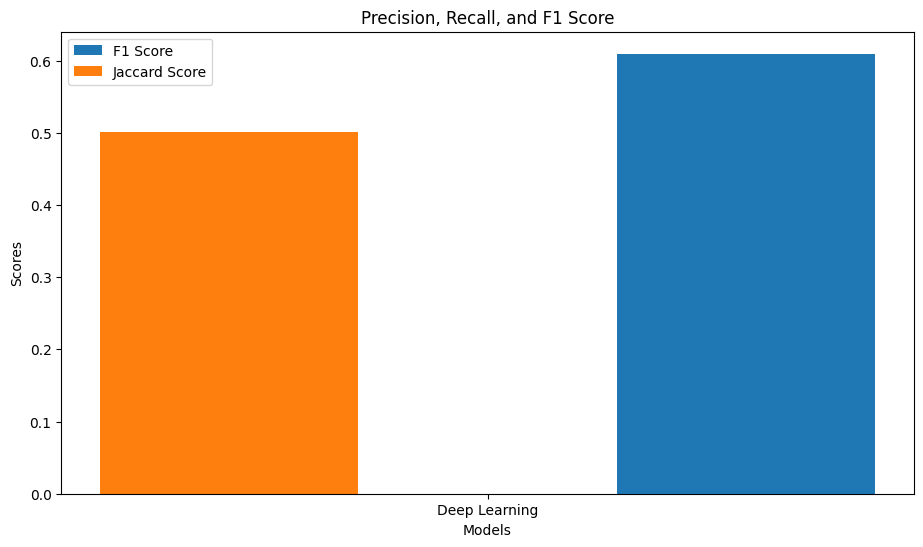

In [73]:
# Prepare data for plotting
labels = precision.keys()
precision_values = precision.values()
recall_values = recall.values()
jaccard_score_values = jaccard.values()
f1_values = f1.values()

# Set the position of the bars on the x-axis
x = range(len(labels))

# Width of a bar
bar_width = 0.2
# Create the plot
fig, ax = plt.subplots(figsize=(11, 6))

# Plot bars
# ax.bar(x, precision_values, width=bar_width, label='Precision', align='center')
# ax.bar([p + bar_width for p in x], recall_values, width=bar_width, label='Recall', align='center')
ax.bar([p + bar_width * 2 for p in x], f1_values, width=bar_width, label='F1 Score', align='center')
ax.bar(x, jaccard_score_values, width=bar_width, label='Jaccard Score', align='center')


# Set the labels for the x-axis
ax.set_xticks([p + bar_width for p in x])
ax.set_xticklabels(labels)

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score')
ax.legend()

# Show the plot
plt.show()